## Mean and Standard Deviation of the images

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
os.listdir("./Dataset/archive/training/training")

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [8]:
training_dataset_path = "./Dataset/archive/training/training"

In [9]:
training_transforms = transforms.Compose([
    # This will change the dimensions of all the images to 224 X 224
    transforms.Resize((224, 224)), 
    # This change the data type of the values in the images from numpy to Tensor
    transforms.ToTensor()
    ])

In [10]:
train_dataset = torchvision.datasets.ImageFolder(
    # root: Path for the training dataset
    root = training_dataset_path, 
    # Adding the transforms on all the images in the dataset
    transform = training_transforms
    )

In [11]:
# Getting the data ready for the ML model
train_loader = torch.utils.data.DataLoader(
    # Variable of the dataset
    dataset = train_dataset,
    # Defining the batch size
    batch_size = 32,
    shuffle = False
    )

The method we using will give us the approx mean and standard deviation. We can get the accurate mean and std by taking all the images instead in batches.

In [16]:
def get_mean_and_std(loader):
    # Initiating the mean, std and total_images_count with 0
    mean = 0
    std = 0
    total_images_count = 0

    # Looping through the batchs of pictures
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        # Reshaping the images from (32, 3, 224, 224) -> (32, 3, 224 X 224)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        # Getting the mean of the values from the 3rd dimension
        mean += images.mean(2).sum(0)
        # Getting the std of the values from the 3rd dimension
        std += images.std(2).sum(0)
        # Summing the number of all the images in all the batches
        total_images_count += image_count_in_a_batch

    # Taking average of both the values
    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [17]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2037]))

## Image Data Preparation

In [18]:
import torchvision
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np

In [22]:
train_dataset_path = "./Dataset/archive/training/training"
test_dataset_path = "./Dataset/archive/validation/validation"

In [20]:
# image = (image - mean) / std

mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

train_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # If we are not passing any values,
                                       # It will by default Flip the images with 50% prob.
    transforms.RandomRotation(10), # Random Rotation to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = ([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [23]:
train_dataset = torchvision.datasets.ImageFolder(
    root = train_dataset_path,
    transform = train_tranforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_dataset_path,
    transform = test_transforms
)

In [30]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = 6,
        shuffle = True
    )
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("Labels : ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels :  tensor([4, 3, 3, 6, 6, 5])


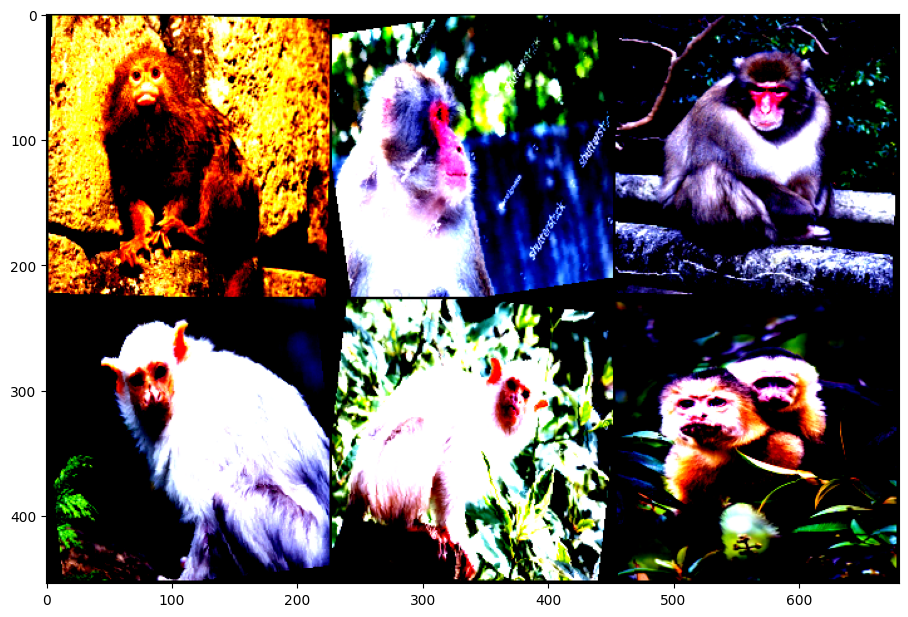

In [31]:
show_transformed_images(train_dataset)

In [33]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = False
)

## Neural Network